In [1]:
from pathlib import Path

import earthkit.data
import earthkit.plots
import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
from numcodecs_combinators.stack import CodecStack
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_wasm_zfp import Zfp
from numcodecs_wasm_zfp_classic import ZfpClassic

In [2]:
t2m = xr.open_dataset(
    Path() / "data" / "era5-daily-2tm-2024-01" / "data.nc",
    engine="netcdf4",
    decode_timedelta=True,
).t2m.chunk({"valid_time": 1})
t2m

<xarray.DataArray 't2m' (valid_time: 31, latitude: 721, longitude: 1440)> Size: 129MB
dask.array<xarray-<this-array>, shape=(31, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * valid_time  (valid_time) datetime64[ns] 248B 2024-01-01 ... 2024-01-31
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [3]:
vmin, vmax = int(np.floor(np.amin(t2m))), int(np.ceil(np.amax(t2m)))
vmin, vmax

(217, 316)

In [4]:
zfp_classic = CodecStack(ZfpClassic(mode="fixed-accuracy", tolerance=1.0))

decoded_zfp_classic = zfp_classic.encode_decode_data_array(t2m).compute()

In [5]:
with xr.set_options(keep_attrs=True):
    error_zfp_classic = (decoded_zfp_classic - t2m).mean(dim="valid_time").compute()
float(np.mean(error_zfp_classic))

-0.006122771184891462

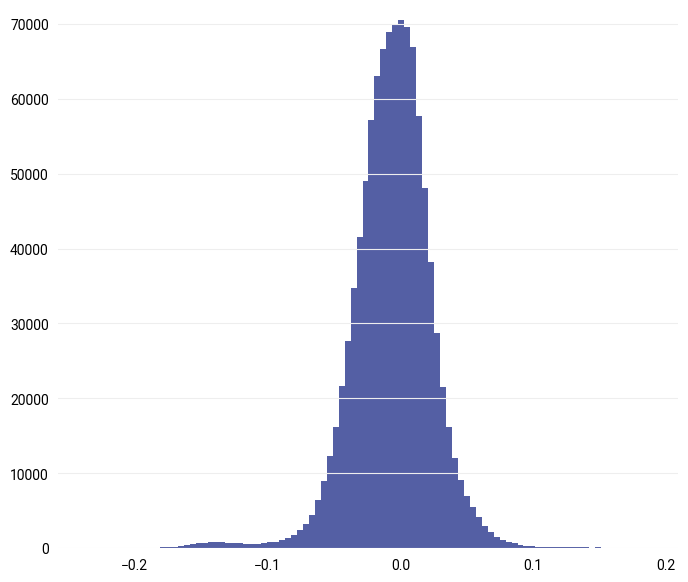

In [6]:
plt.hist(error_zfp_classic.values.flatten(), bins=100)
plt.show()

In [7]:
emin, emax = float(np.amin(error_zfp_classic)), float(np.amax(error_zfp_classic))
emin, emax

(-0.24820241332054138, 0.20027554035186768)

/workspaces/numcodecs-safeguards/.venv/lib/python3.10/site-packages/earthkit/plots/quickplot.py:141: UserWarning: Failed to execute title on given data with: 
unsupported format string passed to NoneType.__format__

consider constructing the plot manually.
  warnings.warn(


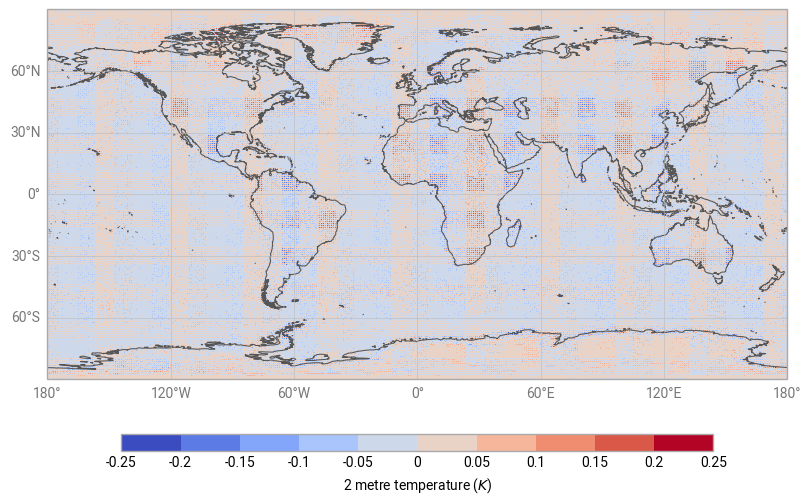

In [8]:
earthkit.plots.quickplot(
    error_zfp_classic,
    style=earthkit.plots.Style(levels=np.linspace(-0.25, 0.25, 11), colors="coolwarm"),
    methods="pcolormesh",
);

In [9]:
zfp = CodecStack(Zfp(mode="fixed-accuracy", tolerance=1.0))

decoded_zfp = zfp.encode_decode_data_array(t2m).compute()

In [10]:
with xr.set_options(keep_attrs=True):
    error_zfp = (decoded_zfp - t2m).mean(dim="valid_time").compute()
float(np.mean(error_zfp))

-5.664207128575072e-05

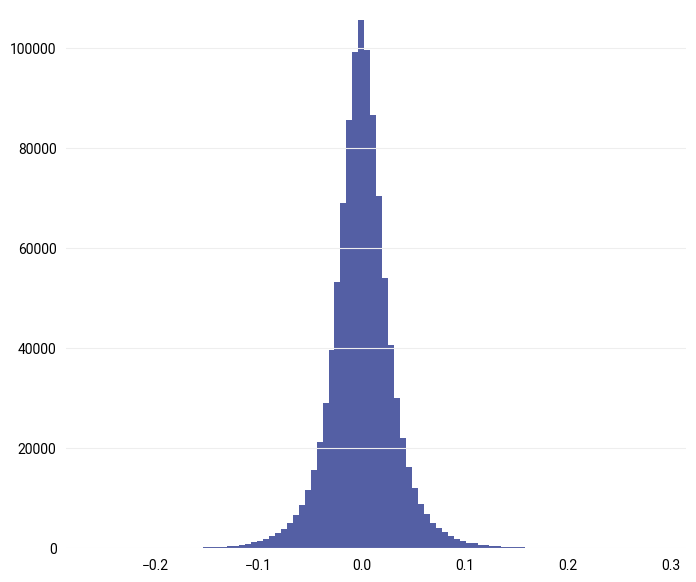

In [11]:
plt.hist(error_zfp.values.flatten(), bins=100)
plt.show()

In [12]:
emin, emax = float(np.amin(error_zfp)), float(np.amax(error_zfp))
emin, emax

(-0.2752527892589569, 0.3035268485546112)

/workspaces/numcodecs-safeguards/.venv/lib/python3.10/site-packages/earthkit/plots/quickplot.py:141: UserWarning: Failed to execute title on given data with: 
unsupported format string passed to NoneType.__format__

consider constructing the plot manually.
  warnings.warn(


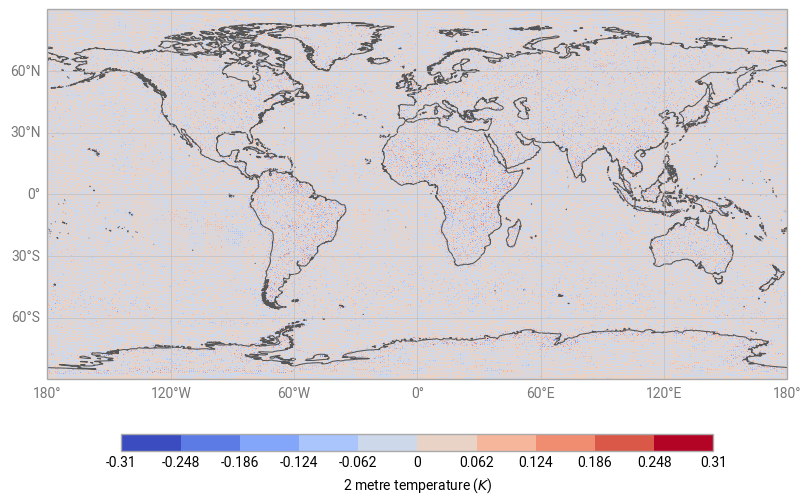

In [13]:
earthkit.plots.quickplot(
    error_zfp,
    style=earthkit.plots.Style(levels=np.linspace(-0.31, 0.31, 11), colors="coolwarm"),
    methods="pcolormesh",
);

In [14]:
zfp_sg = CodecStack(
    SafeguardsCodec(
        codec=ZfpClassic(mode="fixed-accuracy", tolerance=1.0),
        safeguards=[
            dict(kind="abs", eb_abs=0.25),
            dict(kind="bias"),
        ],
    )
)

decoded_zfp_sg = zfp_sg.encode_decode_data_array(t2m).compute()

In [15]:
with xr.set_options(keep_attrs=True):
    error_zfp_sg = (decoded_zfp_sg - t2m).mean(dim="valid_time").compute()
float(np.mean(error_zfp_sg))

0.0004120395169593394

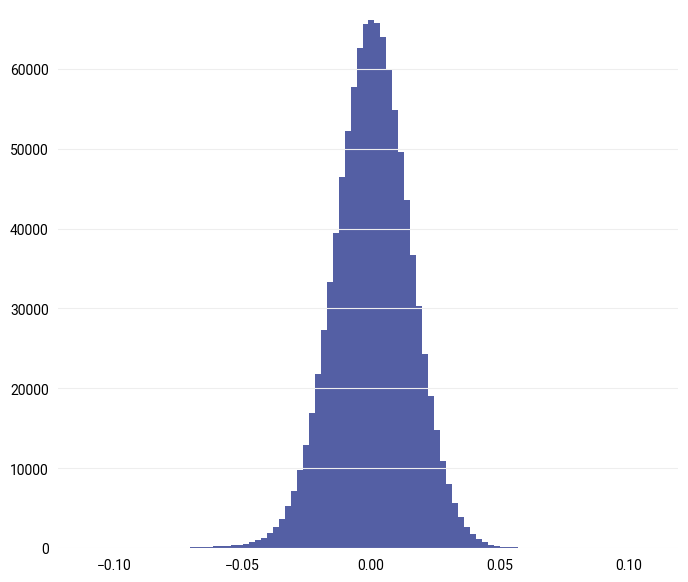

In [16]:
plt.hist(error_zfp_sg.values.flatten(), bins=100)
plt.show()

In [17]:
emin, emax = float(np.amin(error_zfp_sg)), float(np.amax(error_zfp_sg))
emin, emax

(-0.11691776663064957, 0.1148223876953125)

/workspaces/numcodecs-safeguards/.venv/lib/python3.10/site-packages/earthkit/plots/quickplot.py:141: UserWarning: Failed to execute title on given data with: 
unsupported format string passed to NoneType.__format__

consider constructing the plot manually.
  warnings.warn(


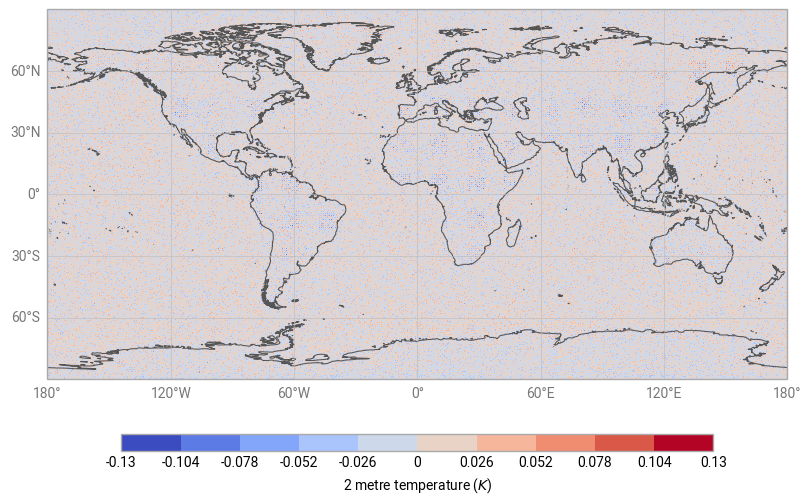

In [18]:
earthkit.plots.quickplot(
    error_zfp_sg,
    style=earthkit.plots.Style(levels=np.linspace(-0.13, 0.13, 11), colors="coolwarm"),
    methods="pcolormesh",
);